In [1]:
pip install faiss-gpu

Note: you may need to restart the kernel to use updated packages.


In [2]:
from datasets import load_dataset
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
from tqdm import tqdm
# from gensim.models import Word2Vec

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU available")
else:
    device = torch.device("cpu")
    print("GPU not available, using CPU")

GPU available


In [3]:
dataset = load_dataset('ms_marco', 'v1.1')
dataset

DatasetDict({
    validation: Dataset({
        features: ['answers', 'passages', 'query', 'query_id', 'query_type', 'wellFormedAnswers'],
        num_rows: 10047
    })
    train: Dataset({
        features: ['answers', 'passages', 'query', 'query_id', 'query_type', 'wellFormedAnswers'],
        num_rows: 82326
    })
    test: Dataset({
        features: ['answers', 'passages', 'query', 'query_id', 'query_type', 'wellFormedAnswers'],
        num_rows: 9650
    })
})

In [4]:
train_data = dataset['train']
validation_data = dataset['validation']
test_data = dataset['test']

train_df = train_data.to_pandas()
train_df.drop(['query_id', 'query_type', 'wellFormedAnswers'], axis=1, inplace=True)
train_df = train_df[:100] #Using small amount of data
train_df.head()

,answers,passages,query
0,[Results-Based Accountability is a disciplined...,"{'is_selected': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]...",what is rba
1,[Yes],"{'is_selected': [0, 1, 0, 0, 0, 0, 0], 'passag...",was ronald reagan a democrat
2,[20-25 minutes],"{'is_selected': [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]...",how long do you need for sydney and surroundin...
3,[$11 to $22 per square foot],"{'is_selected': [0, 0, 0, 0, 0, 0, 0, 0, 1], '...",price to install tile in shower
4,[Due to symptoms in the body],"{'is_selected': [0, 0, 1, 0, 0, 0, 0, 0], 'pas...",why conversion observed in body


In [5]:
passage = []
answer = []

for i in range(len(train_df)):
    x = train_df['answers'][i].tolist()
    if len(x)==0:
        x = "-"
    passage.append((train_df['passages'][i]['passage_text']).tolist())
    answer.append(x[0])

train_df['passages'] = passage
train_df['answers'] = answer
train_df

,answers,passages,query
0,Results-Based Accountability is a disciplined ...,"[Since 2007, the RBA's outstanding reputation ...",what is rba
1,Yes,"[In his younger years, Ronald Reagan was a mem...",was ronald reagan a democrat
2,20-25 minutes,"[Sydney, New South Wales, Australia is located...",how long do you need for sydney and surroundin...
3,$11 to $22 per square foot,"[In regards to tile installation costs, consum...",price to install tile in shower
4,Due to symptoms in the body,"[Conclusions: In adult body CT, dose to an org...",why conversion observed in body
...,...,...,...
95,WatchDog.sys is a vital system file used by th...,[WatchDog.sys was originally stored in the sys...,watchdog.sys what is
96,"In computing, .bak is a filename extension com...",[The easiest way to open a BAK file is to doub...,what is a bak file
97,"Public, four-year colleges cost $7,000 for in-...",[A: The degree that you need to be a detective...,How much will it cost to go to college to beco...
98,A document used to change one or more minor pr...,[Trust Restatement Law & Legal Definition. A r...,trust amendment term


In [6]:
# train_df = train_df.explode('passages')
# train_df = train_df.reset_index(drop = True)
train_df = train_df[['query', 'answers', 'passages']]
train_df

,query,answers,passages
0,what is rba,Results-Based Accountability is a disciplined ...,"[Since 2007, the RBA's outstanding reputation ..."
1,was ronald reagan a democrat,Yes,"[In his younger years, Ronald Reagan was a mem..."
2,how long do you need for sydney and surroundin...,20-25 minutes,"[Sydney, New South Wales, Australia is located..."
3,price to install tile in shower,$11 to $22 per square foot,"[In regards to tile installation costs, consum..."
4,why conversion observed in body,Due to symptoms in the body,"[Conclusions: In adult body CT, dose to an org..."
...,...,...,...
95,watchdog.sys what is,WatchDog.sys is a vital system file used by th...,[WatchDog.sys was originally stored in the sys...
96,what is a bak file,"In computing, .bak is a filename extension com...",[The easiest way to open a BAK file is to doub...
97,How much will it cost to go to college to beco...,"Public, four-year colleges cost $7,000 for in-...",[A: The degree that you need to be a detective...
98,trust amendment term,A document used to change one or more minor pr...,[Trust Restatement Law & Legal Definition. A r...


In [7]:
i = 65
train_df['query'][i], train_df['answers'][i], train_df['passages'][i]

('example of involuntary muscle tissue is',
 'A beating heart',
 ['Involuntary muscles are muscles that are not controllable consciously, and instead contract due to unconscious impulses sent by the autonomic nervous system or certain specialized cells or hormones. Both smooth muscle and cardiac muscle can be classified as involuntary muscles. A beating heart is one of the best examples of an involuntary muscle. Contractions of cardiac muscles push blood through the four chambers of the human heart. The process of peristalsis, which pushes food through the esophagus and small intestine, is controlled by',
  'Muscles are are classified both functionally as either voluntary or involuntary and structurally as either striated or smooth. From this, there emerges three types of muscle s: smooth involuntary (smooth) muscle, striated voluntary (skeletal) muscle and striated involuntary (cardiac) muscle. ',
  'Best Answer: voluntary muscles allow you to move them in voluntary muscles you have n

In [8]:
type(train_df['query'][i]), type(train_df['answers'][i]), type(train_df['passages'][i])

(str, str, list)

In [9]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer, models
import faiss
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim

In [10]:
# Preprocessing
class QADataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        query, answer, docs = self.data.iloc[idx]
        return query, answer, docs

# Load and preprocess data
dataset = QADataset(train_df)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

In [11]:
# Visualizing the final inputs to the model
for i,j,k in dataloader:
    print(i)
    print(j)
    print(k)
    # print(type(k[0]))
    break

len(dataloader)

('what is rba',)
('Results-Based Accountability is a disciplined way of thinking and taking action that communities can use to improve the lives of children, youth, families, adults and the community as a whole.',)
[("Since 2007, the RBA's outstanding reputation has been affected by the 'Securency' or NPA scandal. These RBA subsidiaries were involved in bribing overseas officials so that Australia might win lucrative note-printing contracts. The assets of the bank include the gold and foreign exchange reserves of Australia, which is estimated to have a net worth of A$101 billion. Nearly 94% of the RBA's employees work at its headquarters in Sydney, New South Wales and at the Business Resumption Site.",), ("The Reserve Bank of Australia (RBA) came into being on 14 January 1960 as Australia 's central bank and banknote issuing authority, when the Reserve Bank Act 1959 removed the central banking functions from the Commonwealth Bank. The assets of the bank include the gold and foreign exc

100

In [12]:
# Testing sentence-transformers
sentences = ["This is an example sentence", "Each sentence is converted"]

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
embeddings = model.encode(sentences)
print(len(embeddings[0])) # Creates 384 dimensional vector
embeddings[0]

384


array([ 6.76569119e-02,  6.34959191e-02,  4.87131178e-02,  7.93049634e-02,
        3.74480970e-02,  2.65278132e-03,  3.93749513e-02, -7.09846290e-03,
        5.93614243e-02,  3.15370224e-02,  6.00980818e-02, -5.29051945e-02,
        4.06067520e-02, -2.59308480e-02,  2.98428405e-02,  1.12689799e-03,
        7.35148787e-02, -5.03819138e-02, -1.22386619e-01,  2.37028636e-02,
        2.97265109e-02,  4.24768478e-02,  2.56337598e-02,  1.99518795e-03,
       -5.69190979e-02, -2.71598008e-02, -3.29035521e-02,  6.60248473e-02,
        1.19007140e-01, -4.58791070e-02, -7.26214871e-02, -3.25840041e-02,
        5.23413680e-02,  4.50552851e-02,  8.25299136e-03,  3.67023945e-02,
       -1.39415096e-02,  6.53918609e-02, -2.64272336e-02,  2.06387340e-04,
       -1.36643061e-02, -3.62810194e-02, -1.95043348e-02, -2.89738458e-02,
        3.94270308e-02, -8.84090811e-02,  2.62425840e-03,  1.36713982e-02,
        4.83063012e-02, -3.11565697e-02, -1.17329173e-01, -5.11690453e-02,
       -8.85287896e-02, -

In [13]:
# Modeling
# Initialize sentence transformer
sentence_transformer = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2').to(device)

# Initialize Faiss index
dim = sentence_transformer.get_sentence_embedding_dimension()
index = faiss.IndexFlatIP(dim)

# Initialize GPT-2 model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

encoder = model.transformer.wte.to(device) # access the encoder (word token embeddings)
decoder = model.lm_head.to(device) # access the decoder (language model head)

In [14]:
# Define model
class QAModel(nn.Module):
    def __init__(self, encoder, decoder):
        super(QAModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, query, docs, answer):
        # Encode query and docs
        print(f"\nquery shape is {query.shape}")
        print(f"\ndocs shape is {docs.shape}")
        print(f"\nanswer shape is {answer.shape}")

        query_emb = torch.tensor(sentence_transformer.encode(query)).to(device)
        print(f"\nquery_emb shape is {query_emb.shape}")

        doc_embs = [torch.tensor(sentence_transformer.encode(doc)).to(device) for doc in docs]
        print(f"\ndoc_embs shape is {doc_embs.shape}")

        # Retrieve top 10 documents
        top_k = 10
        scores, indices = index.search(np.vstack(doc_embs), top_k)
        top_docs = [doc_embs[idx] for idx in indices[0]]

        # Concatenate query and top docs
        input_emb = torch.cat([query_emb] + top_docs, dim=0)

        # Encode input
        encoded = self.encoder(input_emb)

        # Decode answer
        output = self.decoder(encoded, answer)

        return output

In [15]:
model = QAModel(encoder, decoder)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
num_epochs = 1

# Training loop
for epoch in range(num_epochs):
    for query, answer, docs in tqdm(dataloader):
        # Convert query, answer to tensors if not already (adjust based on actual data format)
        if not isinstance(query, torch.Tensor):
            query = torch.tensor(query)  # Add dtype and device as needed, e.g., dtype=torch.long, device=device
        if not isinstance(answer, torch.Tensor):
            answer = torch.tensor(answer)  # Add dtype and device as needed

        query, answer = query.to(device), answer.to(device)
        # Ensure docs is a list of tensors, adjust as necessary based on your actual data
        docs = [torch.tensor(doc).to(device) if not isinstance(doc, torch.Tensor) else doc.to(device) for doc in docs]

        optimizer.zero_grad()
        output = model(query, docs, answer)
        loss = criterion(output, answer)
        loss.backward()
        optimizer.step()

  0%|          | 0/100 [00:00<?, ?it/s]

ValueError: too many dimensions 'str'

documents are ['I love cats ', 'cats are smart ', 'He is a foodie', 'he loves cooking', 'peanut butter', 'pets are awesome']
len of embeddings is 6
<class 'faiss.swigfaiss.IndexFlatIP'>

QUERY : do you have pets
indices are [[5 0 1]]
scores are [[0.59480375 0.502546   0.35444376]]
softmax_scores are tensor([[0.3706, 0.3380, 0.2914]])
softmax_scores shape is torch.Size([1, 3])

TOP 3 SIMILAR DOCUMENTS:

Index is : 5
score is : 0.5948037505149841
pets are awesome

Index is : 0
score is : 0.5025460124015808
I love cats 

Index is : 1
score is : 0.35444375872612
cats are smart 

top_docs is ['pets are awesome', 'I love cats ', 'cats are smart ']

query_embedding is torch.Size([1, 384])
tensor([[ 2.8498e-02, -3.5385e-02,  6.1400e-02,  2.7209e-02, -3.8400e-02,
         -1.6967e-02,  6.1944e-02, -6.2616e-02,  5.1501e-02,  3.3581e-02,
          1.7153e-02, -8.6111e-02, -1.6024e-02,  5.0865e-02,  7.8172e-02,
          2.7200e-02, -7.4065e-02,  2.2618e-02, -7.1670e-02,  1.9253e-02,
         -1.8

/tmp/ipykernel_19434/892656577.py:52: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  query_embedding = torch.tensor([query_embedding])


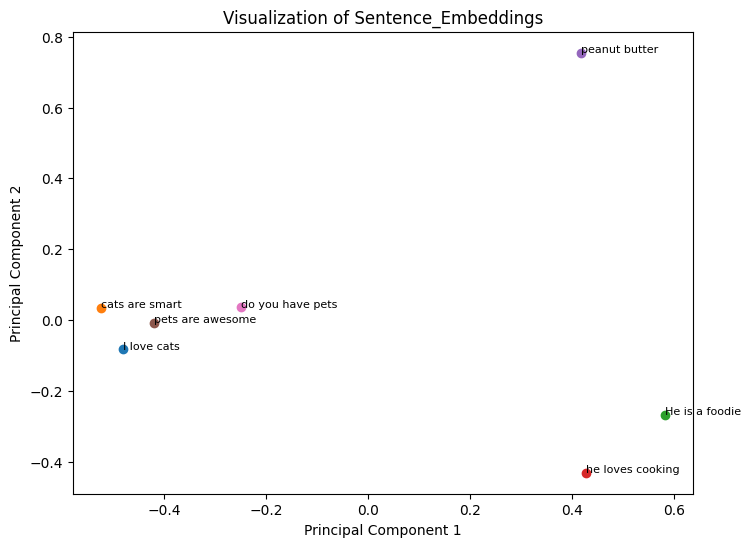

In [16]:
# Visualizing Faiss

import faiss
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

# Load sentence transformer
sentence_transformer = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Sample data
documents = ["I love cats ", "cats are smart ", "He is a foodie", "he loves cooking", "peanut butter", "pets are awesome"]
print(f"documents are {documents}")

# Create Faiss index
dim = sentence_transformer.get_sentence_embedding_dimension()
index = faiss.IndexFlatIP(dim)

# Encode documents
embeddings = [sentence_transformer.encode(doc) for doc in documents]
print(f"len of embeddings is {len(embeddings)}")

# Add embeddings to the index
index.add(np.array(embeddings))
print(type(index))

# Query the index
query = "do you have pets"
print(f"\nQUERY : {query}")
query_embedding = sentence_transformer.encode(query)
top_k = 3  # Retrieve top 2 most similar documents
scores, indices = index.search(np.array([query_embedding]), top_k)

print(f"indices are {indices}")
print(f"scores are {scores}")
scores = torch.tensor(scores)
softmax_scores = torch.softmax(scores, dim =1)
print(f"softmax_scores are {softmax_scores}\nsoftmax_scores shape is {softmax_scores.shape}")

# Print the top-k most similar documents
print(f"\nTOP {top_k} SIMILAR DOCUMENTS:")
for score,idx in enumerate(indices[0]):
    print(f"\nIndex is : {idx}")
    print(f"score is : {scores[0][score]}")
    print(documents[idx])


top_docs = [documents[idx] for idx in indices[0]]
print(f"\ntop_docs is {top_docs}\n")

query_embedding = torch.tensor([query_embedding])
top_docs_embed = torch.cat([torch.tensor(embeddings[idx]).unsqueeze(0) for idx in indices[0]], dim=0)
print(f"query_embedding is {query_embedding.shape}")
print(query_embedding)
print("---------------------------------------------")

print(f"top_docs_embed is {top_docs_embed.size()}")
print(f"top_docs_embed is {top_docs_embed[0].shape, top_docs_embed[1].shape,top_docs_embed[2].shape}")
print(top_docs_embed[0])
print("---------------------------------------------")

# Then concatenate query_embedding with each document embedding along feature dimension
input_emb = torch.cat([query_embedding.expand(top_docs_embed.size(0), -1), top_docs_embed], dim=1)
print(f"\ninput_emb shape: {input_emb.shape}")
print(input_emb[0])
print("---------------------------------------------")


# Visualising
# Retrieve the embeddings from the index
xb = []
for i in range(index.ntotal):
    xb.append(index.reconstruct(i))
xb = np.array(xb)

# Perform PCA to project to 2D
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(xb)

# Create a dictionary to map sentences to their 2D coordinates
sentence_coords = {doc: coords for doc, coords in zip(documents, embeddings_2d)}

# Add the query embedding to the dictionary
sentence_coords[query] = pca.transform(query_embedding.reshape(1, -1))[0]

# Visualize the 2D embeddings
fig, ax = plt.subplots(figsize=(8, 6))
for sentence, coords in sentence_coords.items():
    ax.scatter(coords[0], coords[1])
    ax.annotate(sentence, (coords[0], coords[1]), fontsize=8)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('Visualization of Sentence_Embeddings')
plt.show()

documents are ['I love cats ', 'cats are smart ', 'He is a foodie', 'he loves cooking', 'peanut butter', 'pets are awesome']
Total Documents : 6
[0.98647916 0.6624478  0.21126272 0.97512066]
[0.06711875 0.35323396 0.42123342 0.06831103]
[0.2677246  0.75178665 0.6388946  0.14129175]
[0.9325884  0.39905664 0.3074197  0.10555249]
[0.13662209 0.3350476  0.8270994  0.6268467 ]
[0.35312542 0.78023165 0.50573224 0.12538698]

QUERY : do you have pets

TOP 3 SIMILAR DOCUMENTS:
['I love cats ', 'he loves cooking', 'pets are awesome']

indices are [[0 3 5]]
scores are tensor([[1.4019, 1.0159, 0.9817]])

softmax_scores are tensor([[0.4280, 0.2909, 0.2811]])
softmax_scores shape is torch.Size([1, 3])
---------------------------------------------
concatenated_documents : 
['do you have pets I love cats ', 'do you have pets he loves cooking', 'do you have pets pets are awesome']
Answer : 
no, I dont have


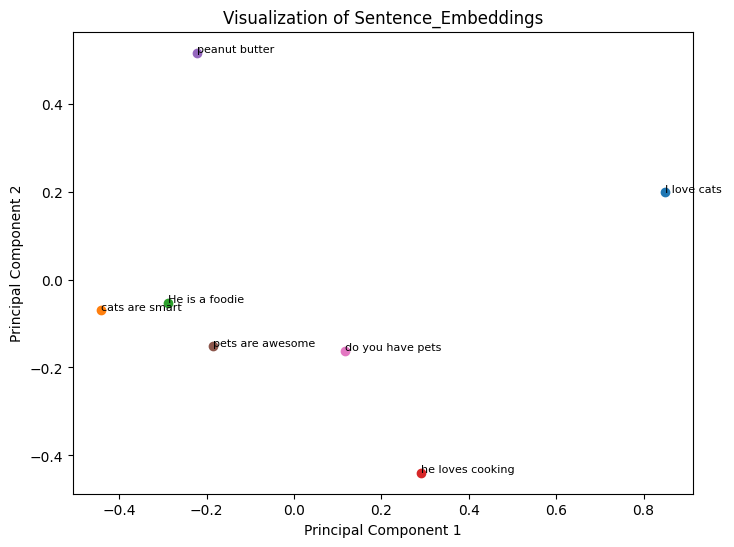

In [21]:
## test 2

# Visualizing Faiss
import faiss
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

# Load sentence transformer
# sentence_transformer = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Sample data
documents = ["I love cats ", "cats are smart ", "He is a foodie", "he loves cooking", "peanut butter", "pets are awesome"]
print(f"documents are {documents}")

# Create Faiss index
dim = 4  # Assuming embedding dimension of 768
index = faiss.IndexFlatIP(dim)

# Generate random embeddings
embeddings = [np.random.rand(dim).astype('float32') for _ in range(len(documents))]
print(f"Total Documents : {len(embeddings)}")
for i in range(len(embeddings)):
    print(embeddings[i])

# Add embeddings to the index
index.add(np.array(embeddings))

# Query the index
query = "do you have pets"
answer = 'no, I dont have'
print(f"\nQUERY : {query}")
query_embedding = np.random.rand(dim).astype('float32')
top_k = 3  # Retrieve top 2 most similar documents
scores, indices = index.search(np.array([query_embedding]), top_k)

scores = torch.tensor(scores)
softmax_scores = torch.softmax(scores, dim =1)


# Print the top-k most similar documents
print(f"\nTOP {top_k} SIMILAR DOCUMENTS:")

top_docs = [documents[idx] for idx in indices[0]]
print(f"{top_docs}\n")
print(f"indices are {indices}")
print(f"scores are {scores}")
print(f"\nsoftmax_scores are {softmax_scores}\nsoftmax_scores shape is {softmax_scores.shape}")
print("---------------------------------------------")

concatenated_documents = [f"{query} {doc}" for doc in top_docs]
print(f"concatenated_documents : \n{concatenated_documents}")
print(f"Answer : \n{answer}")

# Visualising
# Retrieve the embeddings from the index
xb = []
for i in range(index.ntotal):
    xb.append(index.reconstruct(i))
xb = np.array(xb)

# Perform PCA to project to 2D
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(xb)

# Create a dictionary to map sentences to their 2D coordinates
sentence_coords = {doc: coords for doc, coords in zip(documents, embeddings_2d)}

# Add the query embedding to the dictionary
sentence_coords[query] = pca.transform(query_embedding.reshape(1, -1))[0]

# Visualize the 2D embeddings
fig, ax = plt.subplots(figsize=(8, 6))
for sentence, coords in sentence_coords.items():
    ax.scatter(coords[0], coords[1])
    ax.annotate(sentence, (coords[0], coords[1]), fontsize=8)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('Visualization of Sentence_Embeddings')
plt.show()

In [19]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Load pre-trained T5 model and tokenizer
model_name = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

# Example text
text = "translate English to German: The house is wonderful."
input_ids = tokenizer(text, return_tensors="pt").input_ids

# Generate the output
outputs = model.generate(input_ids)
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

print(generated_text)

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Das Haus ist wunderbar.


In [56]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Load pre-trained T5 model and tokenizer
model_name = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

inputs = tokenizer(concatenated_documents, padding=True, truncation=True, max_length=512, return_tensors="pt")
labels = tokenizer(answer, padding=True, truncation=True, max_length=512, return_tensors="pt").input_ids

print(f"inputs['input_ids'] {inputs['input_ids'].shape} \n{inputs['input_ids']}")
print(f"\ninputs['attention_mask'] {inputs['attention_mask'].shape} \n{inputs['attention_mask']}")
print(f"\nlabels {labels.shape} \n{labels}\n")

print(tokenizer.tokenize('do you have pets I love cats '), tokenizer.convert_tokens_to_ids(['▁do', '▁you', '▁have', '▁pets', '▁I', '▁love', '▁cats']))
print(tokenizer.tokenize('no, I dont have'), tokenizer.convert_tokens_to_ids(['▁no', ',', '▁I', '▁dont', '▁have']))


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


inputs['input_ids'] torch.Size([3, 9]) 
tensor([[  103,    25,    43,  8636,    27,   333, 10003,     1,     0],
        [  103,    25,    43,  8636,     3,    88,  5682,  3875,     1],
        [  103,    25,    43,  8636,  8636,    33,  2879,     1,     0]])

inputs['attention_mask'] torch.Size([3, 9]) 
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0]])

labels torch.Size([1, 6]) 
tensor([[ 150,    6,   27, 2483,   43,    1]])

['▁do', '▁you', '▁have', '▁pets', '▁I', '▁love', '▁cats'] [103, 25, 43, 8636, 27, 333, 10003]
['▁no', ',', '▁I', '▁dont', '▁have'] [150, 6, 27, 2483, 43]


In [61]:
tokenizer.convert_tokens_to_ids(['▁no']), tokenizer.decode(['▁no'])

[150]

In [51]:
outputs = model(**inputs, labels=labels)

RuntimeError: The size of tensor a (27) must match the size of tensor b (9) at non-singleton dimension 3

In [75]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Initialize the tokenizer and model
tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")

# Define the input text and the expected answer
input_text = 'do you have pets I love cats '
target_text = "no, I dont have"  # Hypothetical correct translation

print("\n")
print(tokenizer.tokenize(input_text), tokenizer.convert_tokens_to_ids(['▁do', '▁you', '▁have', '▁pets', '▁I', '▁love', '▁cats']))
print(tokenizer.tokenize(target_text), tokenizer.convert_tokens_to_ids(['▁no', ',', '▁I', '▁dont', '▁have']))


# Encode the inputs and labels
input_ids = tokenizer(input_text, return_tensors="pt").input_ids
print(f"\ninput_ids is {input_ids}")

labels = tokenizer(target_text, return_tensors="pt").input_ids
print(f"\nlabels is {labels}")
print(tokenizer.decode([ 150,    6,   27, 2483,   43,    1]))

print(labels[:, :-1])
# Prepare decoder_input_ids which are typically shifted right for T5
# This means appending the EOS token at the end of the labels and slicing off the last token
decoder_input_ids = labels[:, :-1]
print(f"decoder_input_ids is {decoder_input_ids}")

labels = labels[:, 1:]  # Labels need to be shifted left so that it does not include the BOS token
print(f"labels {labels}")

# Get the model's output
outputs = model(input_ids=input_ids, labels=labels, decoder_input_ids=decoder_input_ids)
loss = outputs.loss
logits = outputs.logits
print(f"\nlogits shape: {logits.shape}")
print(f"\nLoss: {loss.item()}")

# If you need to see the predictions
predictions = logits.argmax(dim=-1)
print("\nPredicted Token IDs:", predictions)
print("Predicted Text:", tokenizer.decode(predictions[0]))


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.




['▁do', '▁you', '▁have', '▁pets', '▁I', '▁love', '▁cats'] [103, 25, 43, 8636, 27, 333, 10003]
['▁no', ',', '▁I', '▁dont', '▁have'] [150, 6, 27, 2483, 43]

input_ids is tensor([[  103,    25,    43,  8636,    27,   333, 10003,     1]])

labels is tensor([[ 150,    6,   27, 2483,   43,    1]])
no, I dont have</s>
tensor([[ 150,    6,   27, 2483,   43]])
decoder_input_ids is tensor([[ 150,    6,   27, 2483,   43]])
labels tensor([[   6,   27, 2483,   43,    1]])

logits shape: torch.Size([1, 5, 32128])

Loss: 4.213479042053223

Predicted Token IDs: tensor([[ 8636,    27,   333, 10003, 10003]])
Predicted Text: pets I love cats cats
